## Case Study: Stock Price Prediction 


<h4> The Case study is to predict Next day stock price [Adj Close Price] using  regression analysis</h4>
<p>
    We will be using Nifty 50 data for this case study<br>
    The filename '^NSEI.csv' contains the data<br>
    You need to generate  technical indicators as given below as  Features for converting Time Series to Supervised Learning Problem <br>
   <a href='https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/'> Convert time Series to Supervised Learning</a><p>
    <ul>
        <li> Moving Averages (Example Given : 3Period Moving Avearage (3MA)) </li>
        <li> Previous Day Returns </li>
        <li> Relative Stock returns </li>
    </ul>
<br>
Then you need to Train a Supervised learning algorithm and perform prediction.<br>
<a href='https://blog.quantinsti.com/random-forest-algorithm-in-python/'>Example for your Refrence </a><br>
<b> Make sure  to shift the feature by 1 period so that you will have data from t-1 period to predict price at t (look ahead bias) </b>

<strong> Please consider Testing Period after  01-01-2019 </strong>
</p>
<p>
    <b> Metrics for Evaluation </b>
    <ul>
        <li><strong> RMSE </strong></li>
     </ul>
</p>
<p> Some additional Documention for your help
    <ul>
        <li><a href='https://pandas.pydata.org/docs/'> Pandas Documentation </a> </li>
        <li><a href='https://scikit-learn.org/stable/'> Scikit Learn </a></li>
        </ul>
        </p>

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from pandas.plotting import autocorrelation_plot

In [14]:
# Reading the Stock 
df=pd.read_csv("^NSEI.csv")

In [15]:
# Getting the head of the data
df.head()

Date         Open         High          Low        Close  \
0  2007-09-17  4518.450195  4549.049805  4482.850098  4494.649902   
1  2007-09-18  4494.100098  4551.799805  4481.549805  4546.200195   
2  2007-09-19  4550.250000  4739.000000  4550.250000  4732.350098   
3  2007-09-20  4734.850098  4760.850098  4721.149902  4747.549805   
4  2007-09-21  4752.950195  4855.700195  4733.700195  4837.549805   

     Adj Close  Volume  
0  4494.649902     0.0  
1  4546.200195     0.0  
2  4732.350098     0.0  
3  4747.549805     0.0  
4  4837.549805     0.0

# Level terms linear regression and KNN with different shifts

(0.975, 1.0)

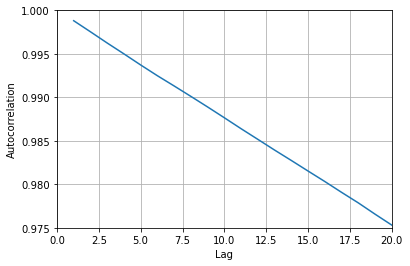

In [16]:
# Selecting Adj Close
df=df[['Date','Adj Close']]
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)

### shifting Features
df['Shifted close']=df['Adj Close'].shift(1)
df['daily return']=df['Adj Close'].pct_change()
df['daily return shifted']=df['daily return'].shift(1)
df['n week return shifted']=df['Adj Close'].pct_change(5).shift(1)
clean_data=df.dropna()

#Auto correlation plot shows Adj Close has high auto correlation with a shift of 1. 
#Gives better results than a moving avg on further testing. 
#Will proceed with Adj close shifted by 1 as one of the independent variables
ax=autocorrelation_plot(clean_data['Adj Close'])
ax.set_xlim([0,20])
ax.set_ylim([0.975,1])

In [17]:
#A function to find the best model by iterating over different shifts of the independent variables
#Used this to find whether any particular shift helps improve the RMSE

def best_model_finder(i, df):
    
    ### shifting Features based on i
    df['Shifted close']=df['Adj Close'].shift(i)
    df['daily return']=df['Adj Close'].pct_change()
    df['daily return shifted']=df['daily return'].shift(i)
    df['n week return shifted']=df['Adj Close'].pct_change(i*5).shift(i)
    clean_data=df.dropna()
    
    # Train Test Split  data. Not using n week return here as I tested it and it did not help
    features=clean_data[['Shifted close','daily return shifted']]
    x_train=features[:'2018']
    x_test=features['2019':]

    dependent=clean_data['Adj Close']
    y_train=dependent[:'2018']
    y_test=dependent['2019':]
    
    if i == 1:
        print("Model   RMSE   TestRsqd   TrainRsqd")
    print('Shift: {}'.format(i))
    LRmodel(i,x_train,x_test,y_train, y_test)
    KNNmodel(i,x_train,x_test,y_train, y_test)
    

def LRmodel(i,x_train,x_test,y_train, y_test):
# Function to run a Linear regression
    LR=LinearRegression()
    LR.fit(x_train,y_train)
    y_pred = LR.predict(x_test)
    
    print("LR \t {}   {} \t {}".format(round(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),1),round(100*r2_score(y_test,y_pred),1),round(100*r2_score(y_train,LR.predict(x_train)),1)))

def KNNmodel(i,x_train,x_test,y_train, y_test):
# Function to run K nearest neighbors model
    Kvalue=[]
    KNNRMSE=[]
    KNNtestrsqd=[]
    KNNtrainrsqd=[]
 
    for K in range(30):
        K = K+1
        KNN = KNeighborsRegressor(n_neighbors = K)
        KNN.fit(x_train,y_train)
        y_KNNpred = KNN.predict(x_test)
        KNNresult=pd.DataFrame()
        
        Kvalue.append(K)
        KNNRMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_KNNpred)))
        KNNtestrsqd.append(100*r2_score(y_test,y_KNNpred))
        KNNtrainrsqd.append(100*r2_score(y_train,KNN.predict(x_train)))
        
    print("{}NN \t {}   {} \t {}".format(KNNRMSE.index(min(KNNRMSE))+1,round(min(KNNRMSE),1),round(KNNtestrsqd[KNNRMSE.index(min(KNNRMSE))],1),round(KNNtrainrsqd[KNNRMSE.index(min(KNNRMSE))],1)))
   

In [18]:
for i in range(1,10):
    best_model_finder(i,df) 

print("LR model with 1 shift for Adj Close along with daily return provides the least RMSE and high R sqd for both training and testing set")

Model   RMSE   TestRsqd   TrainRsqd
Shift: 1
LR 	 99.5   95.8 	 99.9
2NN 	 233.3   76.8 	 99.9
Shift: 2
LR 	 145.2   91.0 	 99.7
3NN 	 265.6   69.8 	 99.8
Shift: 3
LR 	 178.7   86.3 	 99.6
2NN 	 283.2   65.7 	 99.8
Shift: 4
LR 	 200.2   82.9 	 99.5
2NN 	 323.3   55.3 	 99.7
Shift: 5
LR 	 218.7   79.6 	 99.3
11NN 	 357.7   45.3 	 99.4
Shift: 6
LR 	 235.5   76.3 	 99.2
11NN 	 393.7   33.9 	 99.3
Shift: 7
LR 	 250.1   73.3 	 99.1
3NN 	 412.9   27.2 	 99.5
Shift: 8
LR 	 261.2   70.8 	 99.0
2NN 	 413.1   27.0 	 99.5
Shift: 9
LR 	 267.9   69.3 	 98.9
2NN 	 439.2   17.5 	 99.5
LR model with 1 shift for Adj Close and daily return provides the least RMSE and high R sqd for both training and testing set


Residuals have 
 (a) approximately zero mean, 
 (b) approximately normal distribution with a long tail 
 (c) are not autocorrelated

Mean of residuals: -0.02


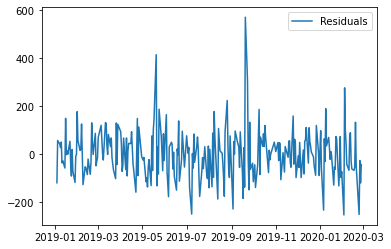

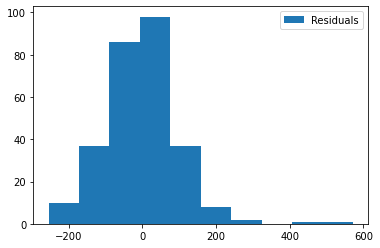

(-0.3, 0.3)

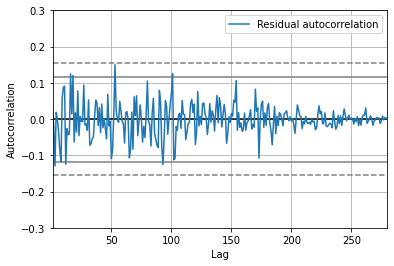

In [8]:
# Choosing the LR model to predict and find residuals
### shifting Features
df['Shifted close']=df['Adj Close'].shift(1)
df['daily return']=df['Adj Close'].pct_change()
df['daily return shifted']=df['daily return'].shift(1)
 
clean_data=df.dropna()
  
# Train Test Split  data. Not using n week return here as I tested it and it did not help
features=clean_data[['Shifted close','daily return shifted']]
x_train=features[:'2018']
x_test=features['2019':]

dependent=clean_data['Adj Close']
y_train=dependent[:'2018']
y_test=dependent['2019':]
    
LR=LinearRegression()
LR.fit(x_train,y_train)
y_pred = LR.predict(x_test)
    
y_resid = y_test - y_pred

print("Residuals have \n (a) approximately zero mean, \n (b) approximately normal distribution with a long tail \n (c) are not autocorrelated")
print("\nMean of residuals: {}".format(round(y_resid.mean(),2)))
plt.plot(y_resid,label="Residuals")
plt.legend()
plt.show()

plt.hist(y_resid,label="Residuals")
plt.legend()
plt.show()

ax=autocorrelation_plot(y_resid,label="Residual autocorrelation")
ax.set_ylim([-0.3,0.3])
